# Generating Burst Data for Reversible Jump MCMC

In this notebook, we will take an example problem for exploring and testing our new sampling methods, and generate test data for it. 

## Imports

In [1]:
%matplotlib notebook
import matplotlib.pyplot as plt

import seaborn as sns

sns.set_style("whitegrid")

import numpy as np

np.random.seed(100)

## The Example Problem

We observe bursts from magnetars that are are recorded as time series of $N$ pairs of time stamps $t_i$ and flux values $y_i$, such that $D = (t_i, y_i)_{i=i}^{N}$. We record this data with X-ray telescopes, which record the arrival time of individual photons with a time resolution of up to $2 \times 10^{6}$ seconds.
Bursts are typically of the order of $~0.2$ seconds long, and time series are constructed by binning individual photon arrivals into regularly spaced bins of a time resolution that can be freely chosen, as long as it is above the resolution of the instrument. The resulting time series consists of Poisson-distributed count data. 

We would like to model the burst time series with a superposition of individual model components $f(t, \theta)$ with parameters $\theta$. For our purposes, $f(t, \theta)$ is defined as a double-sided exponential:

$$
f(t, t_0, A, \sigma, s) = 
\begin{cases}
   A\exp{(t-t_0)/\sigma},& \text{if } t \leq t_0 \\
   A\exp{-(t-t_0)/(s\sigma)}, & \text{if } t > t_0
\end{cases}
$$

The model time series consists of a sum of $K$ components, plus a constant background flux. At every time step $t_i$ we define the model flux $y_{m,i}$ at that position as:

$$
y_{m,i} = y_{\mathrm{bkg}} + \sum_{k=1}^{K}f(t_i, \theta_k)
$$

Let's write a function that generates a single model component:

In [2]:
def twoexp(time, t0, amp, rise, skew):
    """
    Calculate a double-sided exponential at 
    all time steps `t` for the given parameters.
    
    The double-sided exponential consists of a 
    positive exponential $amp exp((time-t0)/rise)$ for 
    times $time <= t0$, and a negative exponential 
    $amp exp(-(time-t0)/(s*rise)$ for times $ttime > t0$.
    
    Parameters
    ----------
    time : numpy.ndarray
        The array of time stamps for which to compute 
        the model
    
    t0 : float, $\[t[0], t[-1]\]$
        The peak time of the double-sided exponential
        
    amp : float, $\[0, \infty\]$
        The amplitude of the double-sided exponential
        
    rise : float, $\[0, \infty\]$
        The rise time of the positive exponential at 
        $t <= t0$
        
    skew : float $\[0, \infty\]$
        The skewness of the two-sided exponential. For 
        $s > 1$, the fall time will be longer than the 
        rise time. For $s < 1$, the fall time will be 
        shorter than the rise time.
        
    Returns
    -------
    ym : numpy.ndarray
        An array of the same size of $t$, returning the 
        model flux for each time step
    """
    
    tdiff = (time-t0) / rise
    
    ym = np.zeros_like(time)
    ym[time <= t0] = amp * np.exp(tdiff[time <= t0])
    ym[time > t0] = amp * np.exp(-tdiff[time > t0]/skew)
    
    return ym
    

Let's test it out:

In [3]:
time = np.linspace(0, 1.0, 1000)

amp = 2.0
t0 = 0.4
rise = 0.03
skew = 5.0

ymodel = twoexp(time, t0, amp, rise, skew)

<IPython.core.display.Javascript object>


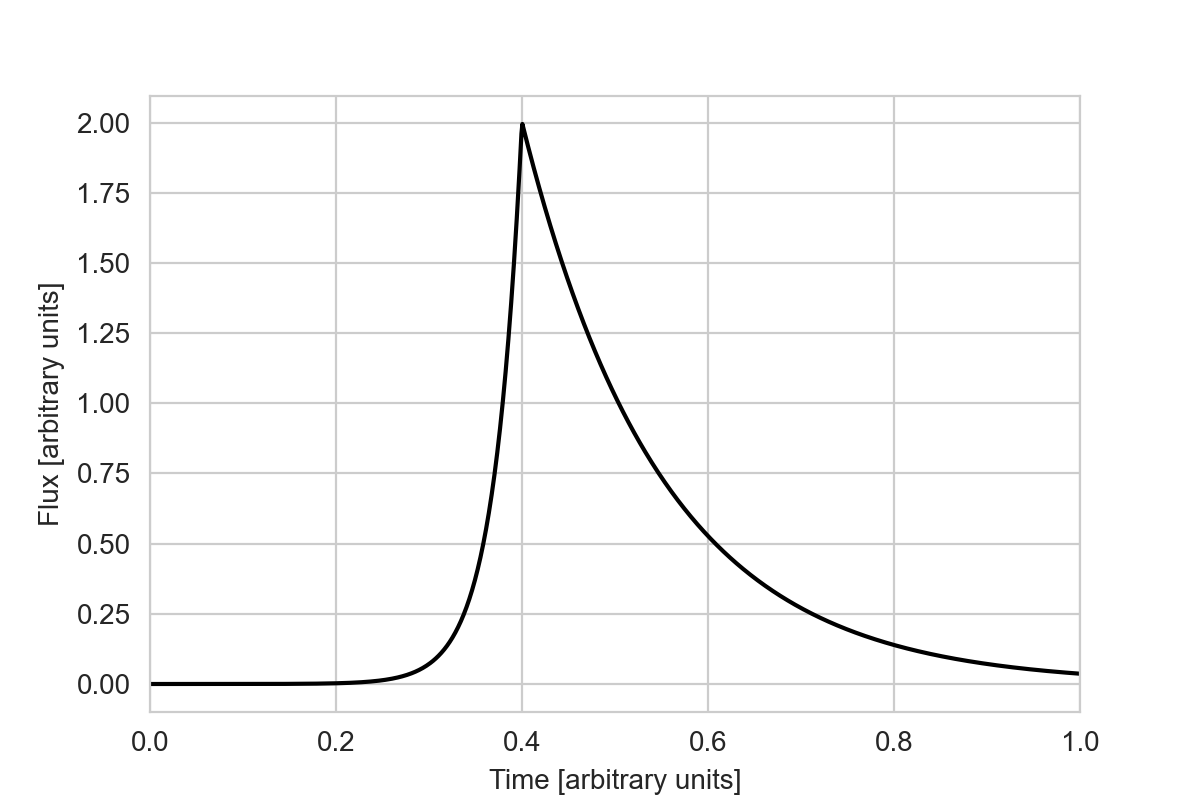

(0.0, 1.0)

In [4]:
fig, ax = plt.subplots(1, 1, figsize=(6,4))

ax.plot(time, ymodel, color="black")
ax.set_xlabel("Time [arbitrary units]")
ax.set_ylabel("Flux [arbitrary units]")
ax.set_xlim(time[0], time[-1])

Now we want a function that combines an arbitrary number of these into a burst:

In [5]:
def combined_twoexp(time, t0, amp, rise, skew, ybkg=0.0):
    """
    This function takes an arbitrary number of components 
    generated by the `two_exp` function and linearly sums them 
    all together. 
    
    `t0`, `amp`, `rise`, `skew` are now arrays of the same 
    length $K$ holding the parameter values for each of the 
    $K$ model components being summed.
    
    Parameters
    ----------
    time : numpy.ndarray
        The array of time stamps for which to compute 
        the model

    t0, amp, rise, skew, ybkg: numpy.ndarray 
        Arrays of the same length $K$ containing 
        the parameters for the `twoexp` function 
        for $K$ components.
        
    ybkg : float, default 0.0
        The constant background flux added to the 
        sum of model components.
        
    Returns
    -------
    ym : numpy.ndarray
        An array of the same size of $t$, returning the 
        model flux for each time step
    """
    ncomp = len(t0)
    
    ym = np.zeros_like(time)
    
    for k in range(ncomp):
        ym += twoexp(time, t0[k], amp[k], rise[k], skew[k])
        
    ym += ybkg
    
    return ym

Let's test this out, too:

In [6]:
ncomp = 3
t0 = np.random.uniform(time[0]+0.1, time[-1]-0.1, size=ncomp)
rise = np.ones(ncomp) * 0.02
amp = np.random.uniform(2, 5, size=ncomp)
skew = np.ones(ncomp)*4

ybkg = 1.0

ymodel = combined_twoexp(time, t0, amp, rise, skew, ybkg)

<IPython.core.display.Javascript object>


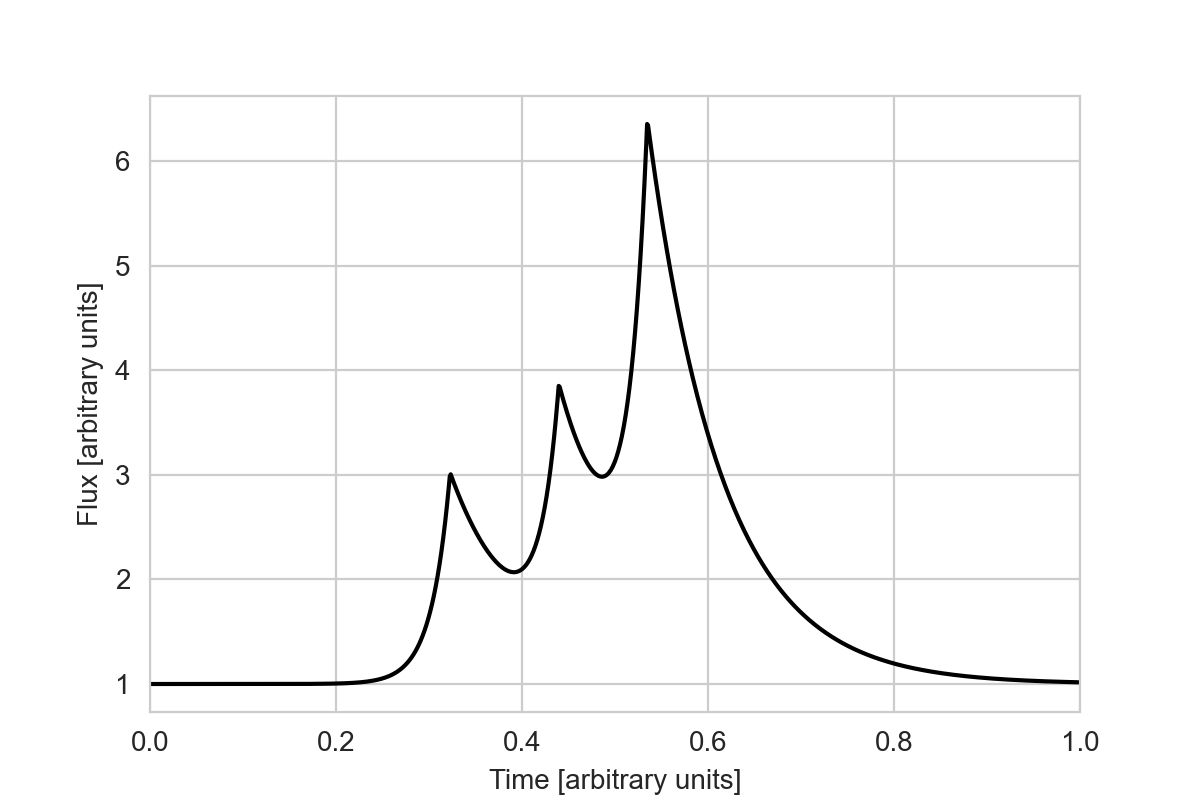

In [7]:
fig, ax = plt.subplots(1, 1, figsize=(6,4))

ax.plot(time, ymodel, color="black")
ax.set_xlabel("Time [arbitrary units]")
ax.set_ylabel("Flux [arbitrary units]")
ax.set_xlim(time[0], time[-1]);

In [8]:
def simulate_burst(time, ncomp, burstparams, ybkg, return_model=False):
    """
    Simulate a realistic burst using a linear combination 
    of `twoexp` function components, a background 
    count rate and poisson noise.
    
    The array `burstparams` contains the parameters for 
    each call of the `twoexp` function. It is a flat 
    array that containts first `ncomp` parameters for `t0`,
    then `ncomp` parameters for the amplitude `amp`, then 
    `ncomp` parameters for the rise time `rise`, and finally
    `ncomp` parameters for the skewness `skew.
    
    Parameters
    ----------
    time : numpy.ndarray
        The array of time stamps for which to compute 
        the model
        
    ncomp : int
        The number of `twoexp` components to include 
        in the sum

    burstparams : iterable
        An array containing the parameters for the 
        `twoexp` model. Flat array of the form
        `[t0_1, ..., t0_K, amp_1, ..., amp_K, 
          rise_1, ..., rise_K, skew_1, ..., skew_k]`
          
    ybkg : float
        The background flux
        
    return_model : bool, default False
        If True, return the model flux (without Poisson
        counts) along with the Poisson-drawn model 
        counts. If False, just contain the Poisson counts

    Returns
    -------
    ycounts : numpy.ndarray
        An array of the same size of $t$, returning the 
        model counts    
    """
    if len(burstparams) != 4*ncomp:
        raise ValueError("`burstparams` must contain all burst model parameters!")
        
    t0 = burstparams[:ncomp]
    amp = burstparams[ncomp:(2*ncomp)]
    rise = burstparams[(2*ncomp):(3*ncomp)]
    skew = burstparams[(3*ncomp):]
    
    ym = combined_twoexp(time, t0, amp, rise, skew, ybkg)
    ycounts = np.random.poisson(ym)
    
    if return_model:
        return ym, ycounts

    else:
        return ycounts

Let's try this, too:

In [9]:
burstparams = np.hstack([t0, amp*10, rise, skew])

ymodel, ycounts = simulate_burst(time, ncomp, burstparams, ybkg*10, return_model=True)

<IPython.core.display.Javascript object>


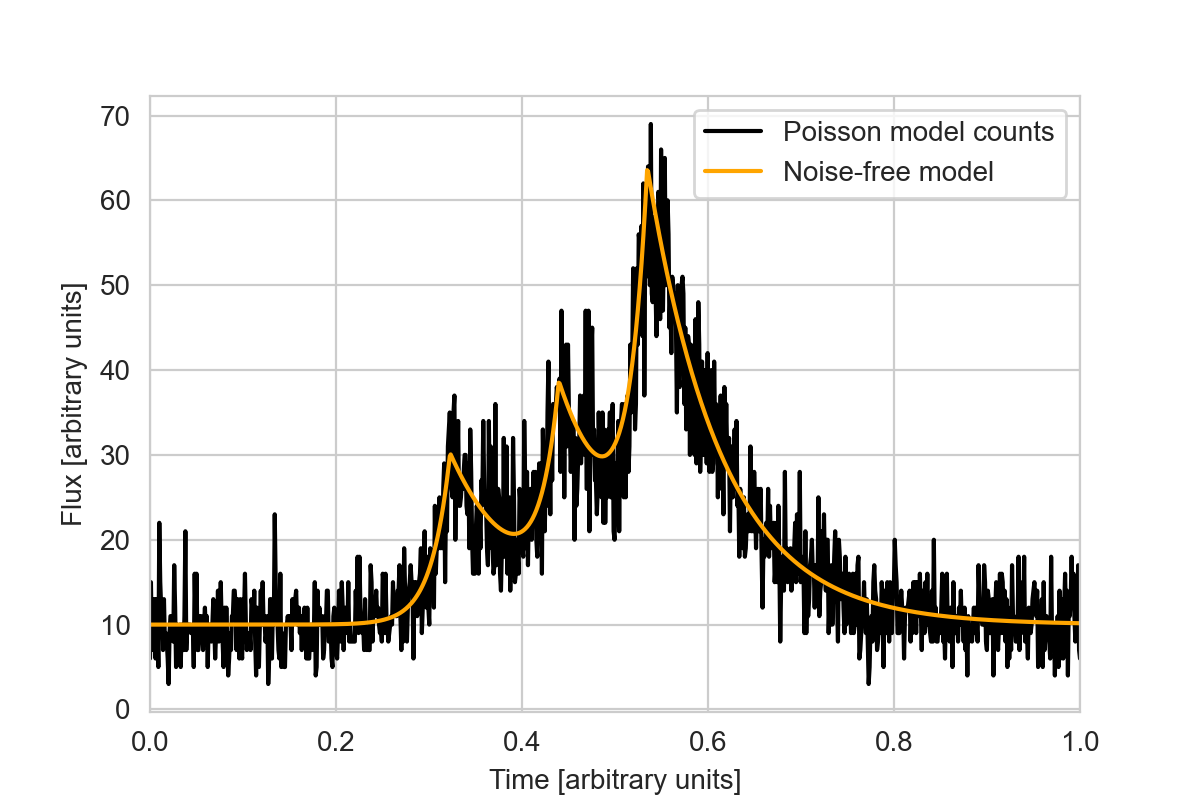

In [10]:
fig, ax = plt.subplots(1, 1, figsize=(6,4))

ax.plot(time, ycounts, color="black", label="Poisson model counts")
ax.plot(time, ymodel, color="orange", label="Noise-free model")
ax.set_xlabel("Time [arbitrary units]")
ax.set_ylabel("Flux [arbitrary units]")
ax.set_xlim(time[0], time[-1]);
ax.legend();